**MODEL SELECTION AND EVALUATION: Part 1**

In [1]:
import src.constants as cn
import src.util as util

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import seaborn as sns
from typing import Optional, List

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Lecture 3: Statistical Methods (Nicoleta & Joe) - May 1
Real-world story about challenges/lessons learned to motivate the rest of the discussion (Nicoleta)
Generalizability
Transferability
Definitions
Model distribution (Nicoleta)
Comparison to simpler methods (joe)
Digits recognition by linear regression
Conversion from deep learning to simpler methods
Types of problems in empirical modeling
Cross-validation & data splitting (joe)
More on balancing data. Choice of training vs. test data. (SMOT? synthetic minority ? technique)
Want uncorrelated data
Feature engineering
Less used in deep learning for image data but can be helpful
How to structure data
Reproducibility
Evaluation (metrics, etc. – based on experimental design)


# Helpers

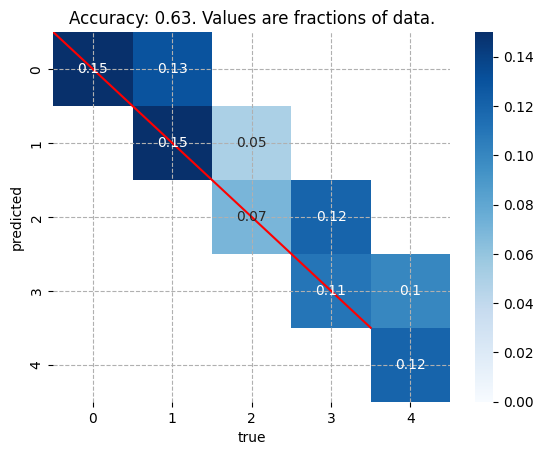

In [11]:
def plotConfusionMatrix(y_true:np.ndarray[int], y_pred:np.ndarray[int]):
    """
    Plots the confusion matrix for the classifications. Values are fraction of data.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    num_label = len(set(y_true))
    data_len = len(y_true)
    mat = tf.math.confusion_matrix(y_true, y_pred)
    frc_mat = np.round(mat/data_len, 2)
    mask_mat = np.repeat(True, num_label*num_label)
    mask_mat = np.reshape(mask_mat, (num_label, num_label))
    for yt in range(num_label):
        for yp in range(num_label):
            if not np.isclose(frc_mat[yp, yt], 0):
                mask_mat[yp, yt] = False
    #
    _ = sns.heatmap(np.transpose(frc_mat), cmap="Blues", annot=True,
                    annot_kws={'fontsize': 10}, 
                    mask=np.transpose(mask_mat),
                 vmin=0)
    accuracy = np.round(balanced_accuracy_score(y_true, y_pred), 2)
    plt.grid(linestyle="--")
    plt.ylabel("predicted")
    plt.xlabel("true")
    plt.plot(range(num_label), range(num_label), c="red")
    plt.title("Accuracy: {accuracy}. Values are fractions of data.".format(accuracy = accuracy))
    plt.show()

# Tests
y_true = np.random.randint(0, 5, 100)
y_pred = y_true + np.random.randint(-1, 1, 100)
y_pred = np.maximum(y_pred, 0)
plotConfusionMatrix(y_true, y_pred)

In [6]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    base_path = os.path.join(cn.DATA_MNIST_SMALL, datatype)
    ddirs = os.listdir(base_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_ddir = os.path.join(base_path, ddir)
        ffiles = os.listdir(this_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(cn.TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

OK!


In [ ]:
def displayImage(flattened_arr:np.ndarray, nrow=28, ncol=28):
    arr = np.reshape(flattened_arr, (nrow, ncol))
    img = Image.fromarray(arr)
    plt.imshow(img)

# Tests
nrow = 5
ncol = 13
arr = np.uint8(np.random.randint(0, 255, nrow*ncol))
displayImage(arr, nrow=nrow, ncol=ncol)

In [ ]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    base_path = os.path.join(cn.DATA_MNIST_SMALL, datatype)
    ddirs = os.listdir(base_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_ddir = os.path.join(base_path, ddir)
        ffiles = os.listdir(this_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(cn.TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

# Data Acquisition & Curation

1. Model constructions depends on data.
2. Pitfalls of simple example of colleciton of data on planes vs. birds

# MNIST Digit Data

# What is a model and how do we evaluate it?

1. Data
1. Inputs to learner and outputs from learner
1. Structure of the learner

The model depends on the task.
1. Classification.
    1. How many classes?
    2. Use case
       1. "Single shot" - Does this picture include my daughter?
       2. Retrieval -- Find all photos of my daughter
1. Regression - Predict numeric values
   1. How old is this brain?
   2. How deep is the snow?

Model evaluation depends on the task
1. Single shot - accuracy
2. Retrieval
   1. Precision - what fraction of the pictures actually contain my daughter
   2. Recall - what fraction of the pictures with my daughter are recalled

## Construct full data of features (X) and labels (y)

***Preparing the data. This can take 30 secs for so.
***Constructing the model.
***Training the model.
Epoch 1/50
4000/4000 - 4s - 1ms/step - accuracy: 0.3287 - loss: 2.4822
Epoch 2/50
4000/4000 - 4s - 1ms/step - accuracy: 0.3847 - loss: 1.7145
Epoch 3/50
4000/4000 - 4s - 1ms/step - accuracy: 0.4090 - loss: 1.5823
Epoch 4/50
4000/4000 - 4s - 1ms/step - accuracy: 0.4521 - loss: 1.4828
Epoch 5/50
4000/4000 - 4s - 1ms/step - accuracy: 0.4967 - loss: 1.3951
Epoch 6/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5068 - loss: 1.3769
Epoch 7/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5231 - loss: 1.3591
Epoch 8/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5404 - loss: 1.3355
Epoch 9/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5474 - loss: 1.3054
Epoch 10/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5516 - loss: 1.2769
Epoch 11/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5651 - loss: 1.2084
Epoch 12/50
4000/4000 - 4s - 1ms/step - accuracy: 0.5629 - loss: 1.1899
Epoch 13/50
4000/4000 - 4s - 1ms/step - ac

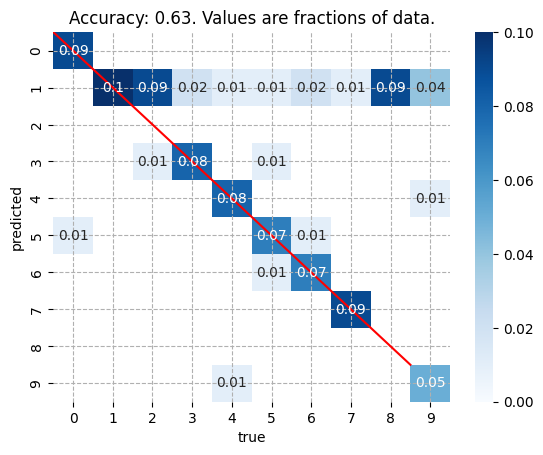

In [18]:
def predictDigits(
    training_count:Optional[int]=None,
    digits:List[int]=range(10),
    hidden1_size:int=8,
    hidden2_size:int=16,
    num_epoc:int=5,
):
    """
    1. Creates the data for the model from the full MNIST dataset.
    2. Constructs a sequential model with specified sizes of hidden layers
    3. Does prediction for the test set (20% the size of the training data)
    4. Displays accuracy and confusion matrix.

    Args:
        training_count: int (number of training images for each class)
            if None, use existing data. (Ignores digits)
        digits: list-int (digits/classes considered)
        hidden1_size: int (number of units in the first hidden layer)
        hidden2_size: int (number of units in the second hidden layer)
        num_epoc: int (number of epochs of training)
    """
    # Create the input data
    if training_count is not None:
        print("***Preparing the data. This can take 30 secs for so.")
        sub_dirs = [str(n) for n in digits]
        util.makeDigitDirs(train_count=training_count, sub_dirs=sub_dirs)
    # Construct training and test data
    X_training, y_training = makeDigitData(cn.TRAINING)
    X_testing, y_testing = makeDigitData(cn.TESTING)
    # Construct the model
    print("***Constructing the model.")
    num_class = len(set(y_training))
    model = keras.Sequential(
        [
            keras.Input(shape=(X_training.shape[-1],)),
            layers.Dense(hidden1_size, activation="relu"),
            layers.Dense(hidden2_size, activation="relu"),
            layers.Dense(num_class, activation="softmax"),
        ]
    )
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    categorical_y_training = to_categorical(y_training)
    # Train the model
    print("***Training the model.")
    history = model.fit(X_training, categorical_y_training, epochs=num_epoc,
                        batch_size=10,
                        verbose=2)
    
    y_pred = model.predict(X_testing).argmax(axis=1)
    print(accuracy_score(y_testing, y_pred))
    
    plotConfusionMatrix(y_testing, y_pred)

# Tests
predictDigits(training_count=4000, num_epoc=50)

In [ ]:
np.shape(categorical_y_training), np.shape(X_training)

In [ ]:
history = model.fit(X_training, categorical_y_training, epochs=1, batch_size=1,
                    verbose=2)
history

In [ ]:
y_pred = model.predict(X_testing).argmax(axis=1)
print(accuracy_score(y_testing, y_pred))

In [ ]:
plotConfusionMatrix(y_testing, y_pred)

In [ ]:
def convertImagesToArrays(dir_path:str)->np.ndarray:
    """
    """

## Model then curate

1. Create a small dataset (1000 images) with 3 digits.
2. Evaluate quality

# 